# PREDICTING DISEASE SPREAD

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

The scope of this project is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

city – City abbreviations: sj for San Juan and iq for Iquitos
week_start_date – Date given in yyyy-mm-dd format
station_max_temp_c – Maximum temperature
station_min_temp_c – Minimum temperature
station_avg_temp_c – Average temperature
station_precip_mm – Total precipitation
station_diur_temp_rng_c – Diurnal temperature range
precipitation_amt_mm – Total precipitation
reanalysis_sat_precip_amt_mm – Total precipitation
reanalysis_dew_point_temp_k – Mean dew point temperature
reanalysis_air_temp_k – Mean air temperature
reanalysis_relative_humidity_percent – Mean relative humidity
reanalysis_specific_humidity_g_per_kg – Mean specific humidity
reanalysis_precip_amt_kg_per_m2 – Total precipitation
reanalysis_max_air_temp_k – Maximum air temperature
reanalysis_min_air_temp_k – Minimum air temperature
reanalysis_avg_temp_k – Average air temperature
reanalysis_tdtr_k – Diurnal temperature range
ndvi_se – Pixel southeast of city centroid
ndvi_sw – Pixel southwest of city centroid
ndvi_ne – Pixel northeast of city centroid
ndvi_nw – Pixel northwest of city centroid

## Data Wrangling & Cleaning¶


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

After importing the libraries, we need to read the files and see the details of the data we are working on

In [2]:
df=pd.read_csv('dengue_features_train.csv')
df_trainlabels=pd.read_csv('dengue_labels_train.csv')
df_test=pd.read_csv('dengue_features_test.csv')

df.head() 

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

There are some null values in different features. We need to select the imputation type.  we can fill the date-time features and other continues numeric vaues with ffill method, using forward propagation  

In [4]:

df.fillna(method='ffill', inplace=True)


# convert weekstartdate to datetime

df['week_start_date']=pd.to_datetime(df['week_start_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

In [6]:
df.describe(include='all')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456,1456.000000,1456.000000,1456,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
unique,2,NaN,NaN,1049,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sj,NaN,NaN,2005-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,936,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,1990-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2010-06-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.031593,26.503434,NaN,0.131271,0.128068,0.202606,0.201987,45.686937,298.697965,...,40.111635,82.176203,45.686937,16.745565,4.898656,27.180313,8.085646,32.443338,22.099863,39.194162
std,NaN,5.408314,15.019437,NaN,0.138527,0.119561,0.074409,0.083592,43.779318,1.361950,...,43.329174,7.161016,43.779318,1.542276,3.542340,1.280861,2.122836,1.960769,1.569113,47.363305
min,NaN,1990.000000,1.000000,NaN,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,NaN,1997.000000,13.750000,NaN,0.039100,0.048250,0.152795,0.144455,9.655000,297.654643,...,13.085000,77.185714,9.655000,15.560000,2.328571,26.300000,6.528571,31.100000,21.100000,8.700000


In [7]:
df.isnull().any(axis=0)

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_t

In [8]:
df_trainlabels.head() 

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [9]:
df_trainlabels.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [10]:
df_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [11]:
df_test.fillna(method='ffill', inplace=True)

We can add total_cases from labels data to training data

In [12]:
df['total_cases']=df_trainlabels['total_cases']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

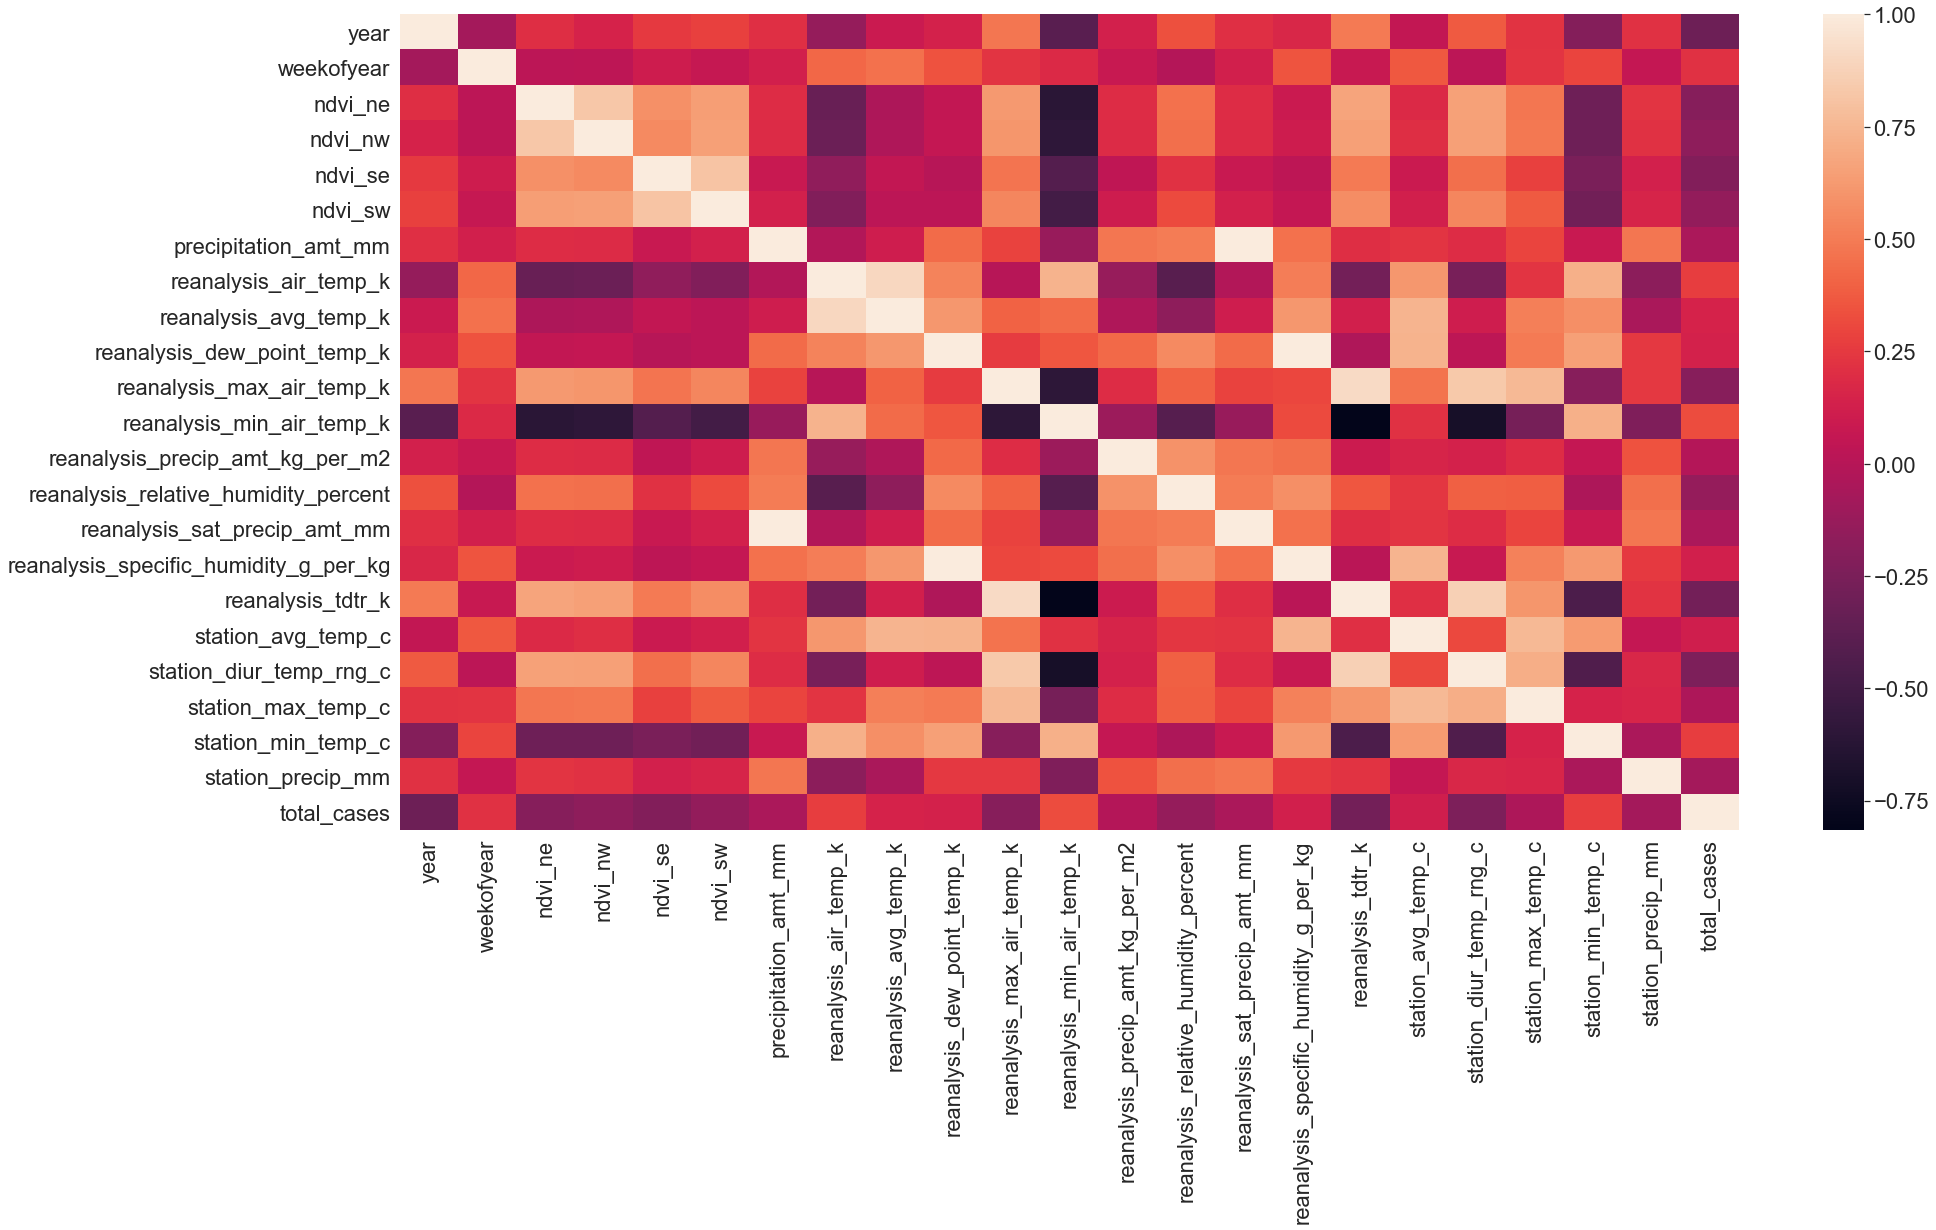

In [13]:
df_corr=df.corr()
sns.set(font_scale=2)
plt.figure(figsize=(30,15))
sns.heatmap(df_corr)
plt.show()

It seems that features are not radically good in correlation with the dependanpt variable 'total cases'

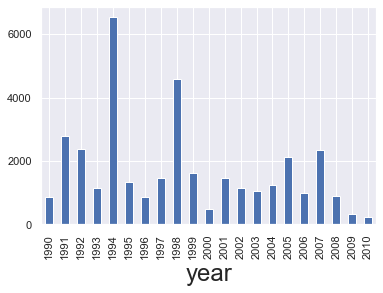

In [14]:
df.groupby(['year']).total_cases.sum().plot( kind='bar', fontsize=11)

We can compare two cities seperately in order to see if there is a difference

Text(0.5, 0, 'YEAR')

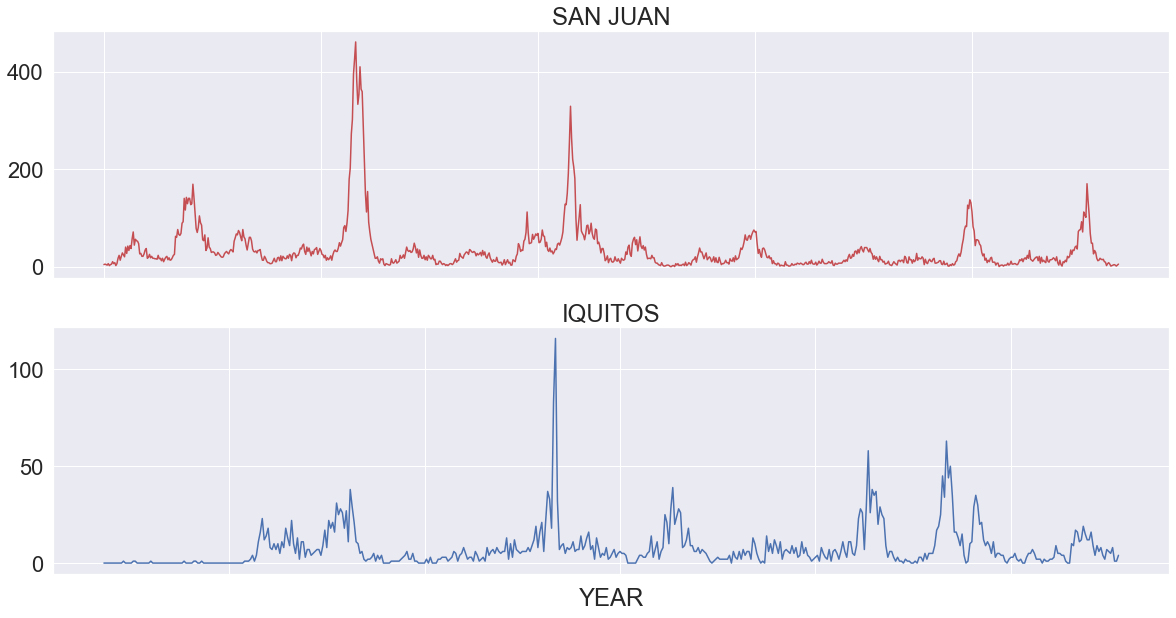

In [15]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

ax1 = df[df['city']=='sj'].total_cases.plot(ax=axes[0], label="San Juan", color='r')
ax1.set_title('SAN JUAN')
ax1.set_xticklabels([])


# plot iq
ax2 = df[df['city']=='iq'].total_cases.plot(ax=axes[1], label="Iquitos")
ax2.set_title('IQUITOS')
ax2.set_xticklabels([])
ax2.set_xlabel("YEAR")



While San Juan have more case during certain times of the year,  for two cities the denisty and the spread of the disease seem parallell. 

Lets check the features seperately by 2 cities
It can be guessed that this fever is a tropical disease, can be expected to be more popular in places with high temperature, 
Thus, the peak season should be summer. 


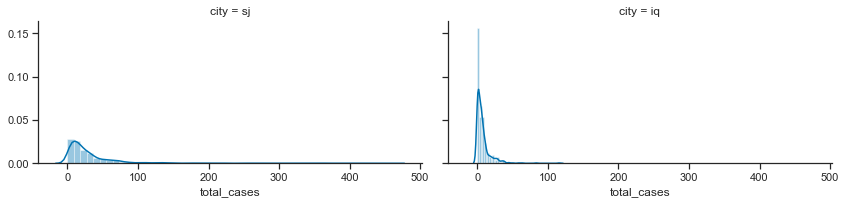

In [16]:
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(df, col="city",aspect=2)  
g.map(sns.distplot, "total_cases")

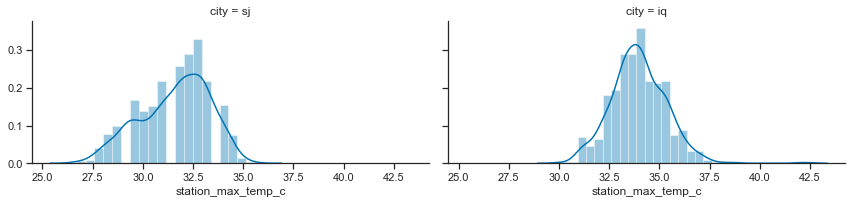

In [17]:
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(df, col="city",aspect=2)  
g.map(sns.distplot, "station_max_temp_c")

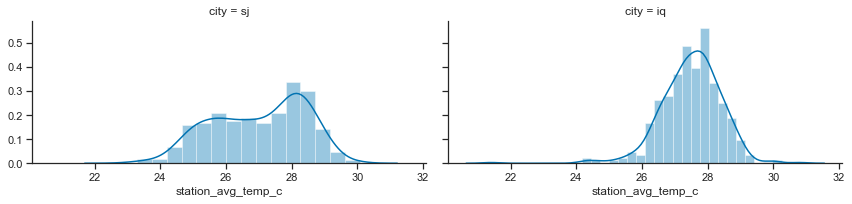

In [18]:
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(df, col="city",aspect=2)  
g.map(sns.distplot, "station_avg_temp_c")

In [19]:
df.drop('year', axis=1, inplace=True)
df.drop('weekofyear', axis=1, inplace=True)
df.drop('week_start_date', axis=1, inplace=True)

df.head()

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   ndvi_ne                                1456 non-null   float64
 2   ndvi_nw                                1456 non-null   float64
 3   ndvi_se                                1456 non-null   float64
 4   ndvi_sw                                1456 non-null   float64
 5   precipitation_amt_mm                   1456 non-null   float64
 6   reanalysis_air_temp_k                  1456 non-null   float64
 7   reanalysis_avg_temp_k                  1456 non-null   float64
 8   reanalysis_dew_point_temp_k            1456 non-null   float64
 9   reanalysis_max_air_temp_k              1456 non-null   float64
 10  reanalysis_min_air_temp_k              1456 non-null   float64
 11  rean

Since two cities are not dependant with each other lets seperate two cities in terms of data sets

In [21]:
sj_train=df[df.city=='sj'].copy()
iq_train=df[df.city=='iq'].copy()
sj_test=df_test[df_test.city=='sj'].copy()
iq_test=df_test[df_test.city=='iq'].copy()


iq_train.head()


,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


## Creating Prediction Models

### San Juan

In [22]:
# split the data, dropping the city name 
X_trainsj = sj_train.drop(labels=['total_cases','city'], axis=1)
y_trainsj = sj_train['total_cases']


X_train, X_test, y_train, y_test = train_test_split(X_trainsj, y_trainsj, shuffle = False, test_size=0.3)

In [23]:
# lets create an evaluation function

def eval_metrics(actual, pred):
    r2 = r2_score(actual, pred)
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    print("r2: {}, mse: {}, mae: {}".format(r2, mse, mae))

In [24]:
# We should decide which regression model to be used
# Lets check the difference between mean and variance in roder to choose a regreion model

print('San Juan')
print('mean: ', sj_train.total_cases.mean())
print('var :', sj_train.total_cases.var())

print('\nIquitos')
print('mean: ', iq_train.total_cases.mean())
print('var :', iq_train.total_cases.var())

San Juan
mean:  34.18055555555556
var : 2640.045439691045

Iquitos
mean:  7.565384615384615
var : 115.89552393656412


It is obvious that the variance is much bigger than the mean. We can use a negative binomial approach

In [25]:
# Linear Regression

lr_sj = LinearRegression()
lr_sj.fit(X_train, y_train)


eval_metrics(y_train, lr_sj.predict(X_train))
eval_metrics(y_test, lr_sj.predict(X_test))


r2: 0.181787747750208, mse: 2753.22024224803, mae: 33.00584994519192
r2: -1.2292246990557492, mse: 1576.9357264452524, mae: 33.52630581352626


In [26]:
# it seems that our model is underfitting. Lets apply standart scaler and pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
est = []
est.append(('standardize', StandardScaler()))
est.append(('LR', LinearRegression()))
pipe = Pipeline(est)

pipe.fit(X_train,y_train)

pipe.score(X_test,y_test)

R2 = r2_score(y_test, pipe.predict(X_test))
MeanabsError = mean_absolute_error(y_test,pipe.predict(X_test))
print('R2 :',R2)
print('MAE: ',MeanabsError)

R2 : -1.2292246990556976
MAE:  33.52630581352533


In [27]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
frst=RandomForestRegressor(n_estimators=100,random_state=0)
frst.fit(X_train,y_train)

eval_metrics(y_train, frst.predict(X_train))
eval_metrics(y_test, frst.predict(X_test))


r2: 0.9422831553940082, mse: 194.21266847442402, mae: 8.968775463467829
r2: -1.183364578964527, mse: 1544.4946442064138, mae: 30.931606507371633


Random forest model created a better result

In [28]:
# Lets apply deep learning with neural networks

from sklearn.neural_network import MLPRegressor


deep = MLPRegressor(max_iter=10000)
deep.fit(X_train, y_train)
y_true_s, y_pred_s = y_test, deep.predict(X_test).astype(int)
print("Mean Absolute Error: %f" %mean_absolute_error(y_true_s, y_pred_s))

Mean Absolute Error: 26.437722


In [29]:
sj_test2=df_test.loc[df_test.city=='sj']
sj_test2.drop(['year','city','weekofyear','week_start_date'], axis=1, inplace=True)

y_pred1 = deep.predict(sj_test2).astype(int)
sub_dfsa= pd.DataFrame(y_pred1, columns=["total_cases"])
sub_dfsa.insert(0, 'city','sj')
sub_dfsa.insert(1, 'year', sj_test['year'])
sub_dfsa.insert(2, 'weekofyear', sj_test['weekofyear'])
sub_dfsa.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,city,year,weekofyear,total_cases
0,sj,2008,18,42
1,sj,2008,19,38
2,sj,2008,20,30
3,sj,2008,21,30
4,sj,2008,22,40


In [30]:
sub_dfsa.shape


(260, 4)

## Iquitos

In [31]:
X_trainiq = iq_train.drop(labels=['total_cases','city'], axis=1)
y_trainiq = iq_train['total_cases']


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_trainiq, y_trainiq, shuffle = False, test_size=0.3)

In [32]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
frst=RandomForestRegressor(n_estimators=100,random_state=0)
frst.fit(X_train,y_train)

eval_metrics(y_train2, frst.predict(X_train2))
eval_metrics(y_test2, frst.predict(X_test2))

r2: -51.373774114152354, mse: 5314.829691483516, mae: 67.67337912087912
r2: -43.66308794851603, mse: 6283.062851282052, mae: 71.83717948717948


In [33]:
# Lets apply deep learning with neural networks

from sklearn.neural_network import MLPRegressor

MLPRegressor()

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [34]:

deep1 = MLPRegressor(max_iter=10000)
deep1.fit(X_train2, y_train2)
y_true_iq, y_pred_iq = y_test2, deep1.predict(X_test2).astype(int)
print("Mean Absolute Error: %f" %mean_absolute_error(y_true_iq, y_pred_iq))

Mean Absolute Error: 7.608974


In [41]:
#Deeplearning has performed better so far,

iq_test2=df_test.loc[df_test.city=='iq']
iq_test2.drop(['year','city','weekofyear','week_start_date'], axis=1, inplace=True)

y_pred2 = deep.predict(iq_test2).astype(int)
sub_dfiq= pd.DataFrame(y_pred2, columns=["total_cases"])
sub_dfiq.insert(0, 'city', 'iq')
sub_dfiq.insert(1, 'year', iq_test['year'])
sub_dfiq.insert(2, 'weekofyear', iq_test['weekofyear'])


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
sub_dfiq.shape

(156, 4)

## Submission

In [37]:
submission = pd.read_csv("submission_format.csv")

In [38]:
submission.total_cases = np.concatenate([sub_dfsa.total_cases, sub_dfiq.total_cases])
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,42
1,sj,2008,19,38
2,sj,2008,20,30
3,sj,2008,21,30
4,sj,2008,22,40
...,...,...,...,...
411,iq,2013,22,51
412,iq,2013,23,44
413,iq,2013,24,43
414,iq,2013,25,32


In [40]:
submission.to_csv("submissionki.csv", index=False)